In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.stats import linregress
files = glob.glob('modis_*_China.csv')
print("✅ 找到的文件：", files)
all_data = []
for file in files:
    try:
        year = int(file.split('_')[1])  # 提取年份
        df = pd.read_csv(file)
        df['year'] = year
        all_data.append(df)
        print(f"{file}: {len(df)} 条记录")
    except Exception as e:
        print(f"读取失败: {file}, 原因: {e}")
#第二步合并与预览
data = pd.concat(all_data, ignore_index=True)
print(f"✅ 成功合并 {len(files)} 个文件，共 {len(data)} 行数据。")

# Step 3. 预览数据列名
print("数据列名：", data.columns.tolist())
print(data.head())

✅ 找到的文件： ['modis_2013_China.csv', 'modis_2018_China.csv', 'modis_2015_China.csv', 'modis_2012_China.csv', 'modis_2019_China.csv', 'modis_2014_China.csv', 'modis_2011_China.csv', 'modis_2017_China.csv', 'modis_2010_China.csv', 'modis_2016_China.csv']
modis_2013_China.csv: 118010 条记录
modis_2018_China.csv: 78673 条记录
modis_2015_China.csv: 122990 条记录
modis_2012_China.csv: 95653 条记录
modis_2019_China.csv: 88539 条记录
modis_2014_China.csv: 150807 条记录
modis_2011_China.csv: 103345 条记录
modis_2017_China.csv: 114317 条记录
modis_2010_China.csv: 103118 条记录
modis_2016_China.csv: 97667 条记录
✅ 成功合并 10 个文件，共 1073119 行数据。
数据列名： ['latitude', 'longitude', 'brightness', 'scan', 'track', 'acq_date', 'acq_time', 'satellite', 'instrument', 'confidence', 'version', 'bright_t31', 'frp', 'daynight', 'type', 'year']
   latitude  longitude  brightness  scan  track    acq_date  acq_time  \
0   39.1092   106.6029       312.3   1.5    1.2  2013-01-01       329   
1   39.1160   106.5980       304.6   1.5    1.2  2013-01-01  

In [10]:
# 验证）
print("各年份数据量分布：")
print(data['year'].value_counts().sort_index())

各年份数据量分布：
year
2010    103118
2011    103345
2012     95653
2013    118010
2014    150807
2015    122990
2016     97667
2017    114317
2018     78673
2019     88539
Name: count, dtype: int64


In [11]:
# Step 2: 数据清洗

#除去重复行
data = data.drop_duplicates()
print(f"After deduplication: {len(data):,}")

# 过滤真实火点（type=0）
# 0 = fire, 1 = uncertain, 2 = non-fire
if 'type' in data.columns:
    original = len(data)
    data = data[data['type'] == 0] 
    print(f"After filtering type==0: {len(data):,} ({original - len(data):,} removed)")
else:
    print("Warning: 'type' column missing — may include non-fire pixels")

# 确保 acq_date 为 datetime 类型
if 'acq_date' not in data.columns:
    raise KeyError("Column 'acq_date' not found. Required for temporal analysis.")
    
data['acq_date'] = pd.to_datetime(data['acq_date'], errors='coerce')#把非法日期转换为NaT
data = data.dropna(subset=['acq_date'])#删除无效日期
data['date'] = data['acq_date'].dt.date  # 把日聚集到一起

# 筛选黑龙江边界框（西起东经121°11′，东至东经135°05′，南起北纬43°26′，北至北纬53°33′）
HLJ_BOUNDS = {
    'lon_min': 121.1,
    'lon_max': 135.0,
    'lat_min': 43.3,
    'lat_max': 53.3
}

mask = (
    (data['longitude'] >= HLJ_BOUNDS['lon_min']) &
    (data['longitude'] <= HLJ_BOUNDS['lon_max']) &
    (data['latitude'] >= HLJ_BOUNDS['lat_min']) &
    (data['latitude'] <= HLJ_BOUNDS['lat_max']) &
    (data['year'] >= 2010) & (data['year'] <= 2019)
)

data_hlj = data[mask].copy()
print(f"Within Heilongjiang (2010–2019): {len(data_hlj):,}")

# 按天和约 1 公里网格进行去重（避免被Terra和Aqua重复记录）
data_hlj['lat1km'] = np.round(data_hlj['latitude'], 2)
data_hlj['lon1km'] = np.round(data_hlj['longitude'], 2)
subset_cols = ['date', 'lat1km', 'lon1km']
if 'satellite' in data_hlj.columns:
    subset_cols.append('satellite')

data_clean = data_hlj.drop_duplicates(subset=subset_cols)
print(f"After daily-spatial deduplication: {len(data_clean):,}")

After deduplication: 1,073,119
After filtering type==0: 991,374 (81,745 removed)
Within Heilongjiang (2010–2019): 288,216
After daily-spatial deduplication: 282,587


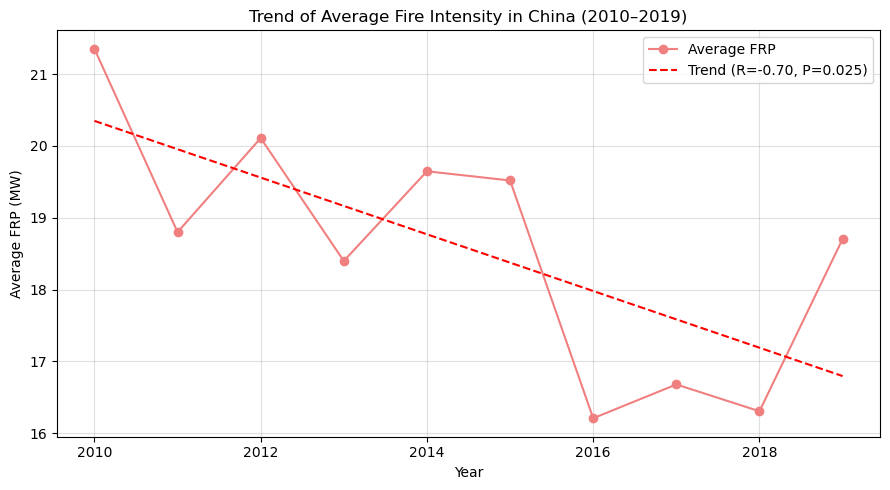

📊 回归分析结果：
斜率 (Slope): -0.3948 MW/年
相关系数 (R): -0.696
P值: 0.025
结论：2010–2019年间，平均火势强度呈显著下降趋势。


In [12]:
# Step 1: 计算每年的平均火势强度（FRP）
annual_avg_frp = data.groupby('year')['frp'].mean()

# Step 2: 线性回归分析趋势
slope, intercept, r_value, p_value, std_err = linregress(annual_avg_frp.index, annual_avg_frp.values)

# Step 3: 绘图
plt.figure(figsize=(9, 5))
plt.plot(annual_avg_frp.index, annual_avg_frp.values,  marker='o',color='lightcoral', label='Average FRP')
plt.plot(annual_avg_frp.index, intercept + slope * annual_avg_frp.index, '--r', label=f'Trend (R={r_value:.2f}, P={p_value:.3f})')

plt.xlabel('Year')
plt.ylabel('Average FRP (MW)')
plt.title('Trend of Average Fire Intensity in China (2010–2019)')
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

# Step 4: 打印结果解释
print(f"📊 回归分析结果：")
print(f"斜率 (Slope): {slope:.4f} MW/年")
print(f"相关系数 (R): {r_value:.3f}")
print(f"P值: {p_value:.3f}")
if p_value < 0.05:
    if slope > 0:
        trend = "显著上升"
    else:
        trend = "显著下降"
else:
    trend = "无显著变化"
print(f"结论：2010–2019年间，平均火势强度呈{trend}趋势。")

In [13]:
# Step 3: 
#按年统计每年有多少个“独立火点”
annual = data_clean.groupby('year').size().reset_index(name='fire_count')

# 补全缺失年份（比如某年没有火点），设为0，避免回归出错
full_years = pd.DataFrame({'year': range(2010, 2020)})
annual = full_years.merge(annual, on='year', how='left').fillna(0).astype({'fire_count': int})
x = annual['year']
y = annual['fire_count']

# 使用线性回归判断趋势
slope, intercept, r_value, p_value, _ = linregress(x, y)
trend_line = slope * x + intercept

print(f"  Slope: {slope:.1f}")
print(f"  R²: {r_value**2:.3f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Conclusion: {'Significant decrease' if slope < 0 and p_value < 0.05 else 'No significant trend'}")

  Slope: 1165.2
  R²: 0.069
  p-value: 0.4636
  Conclusion: No significant trend


Best candidate for turning point: 2018
Before 2018: avg 30540
After 2018: avg 19132
Change: -37.4%


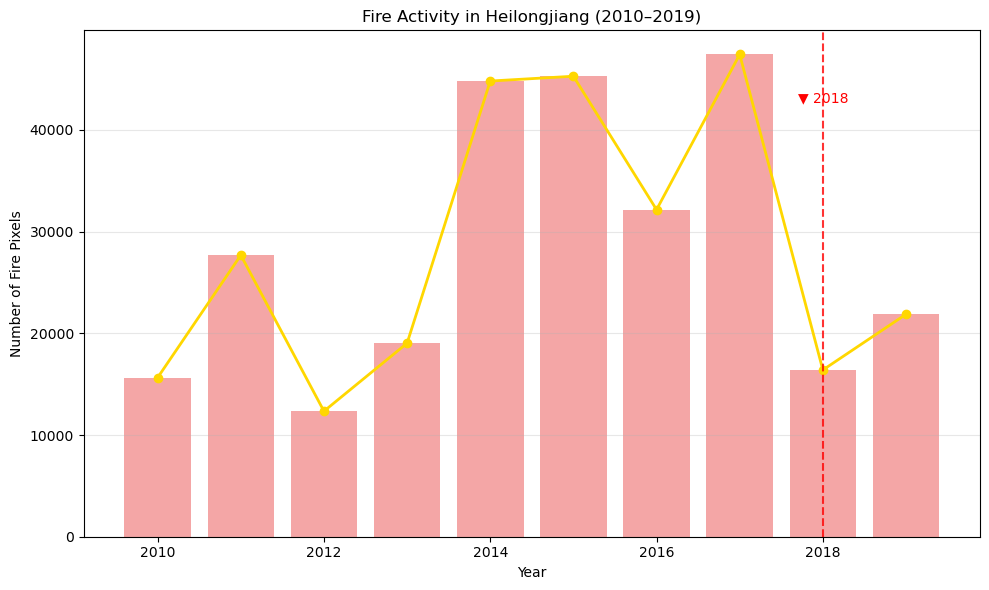

In [15]:
# Step 4 (Final): Smart Turning Point Detection
# Using "Before vs After" mean comparison
years = annual['year'].values
counts = annual['fire_count'].values

candidates = []
for year in range(2010, 2019):  # Test from 2010 to 2019
    before = counts[years < year]
    after = counts[years >= year]
#至少3年前 + 2年后 → 保证统计稳定性    
    if len(before) < 3 or len(after) < 2:
        continue
        
    change = np.mean(after) - np.mean(before)
    relative_change = change / np.mean(before)  # 相对变化率
    
# 显著下降：下降 > 30%，且 after 均值 < before
    if np.mean(after) < np.mean(before) and relative_change < -0.3:
        candidates.append({
            'break_year': year,
            'before_mean': np.mean(before),
            'after_mean': np.mean(after),
            'change': relative_change * 100
        })

# 按变化幅度排序
candidates = sorted(candidates, key=lambda x: x['change'])

if candidates:
    best = candidates[0]
    print(f"Best candidate for turning point: {best['break_year']}")
    print(f"Before {best['break_year']}: avg {best['before_mean']:.0f}")
    print(f"After {best['break_year']}: avg {best['after_mean']:.0f}")
    print(f"Change: {best['change']:.1f}%")
else:
    print("No clear turning point detected")
plt.figure(figsize=(10, 6))
plt.bar(annual['year'], annual['fire_count'], color='lightcoral', alpha=0.7)
plt.plot(annual['year'], annual['fire_count'], 'o-', color='gold', linewidth=2)

# 如果有候选拐点，画线
if candidates:
    cp = candidates[0]['break_year']
    plt.axvline(cp, color='red', linestyle='--', alpha=0.8)
    plt.text(cp, max(annual['fire_count'])*0.9, f'▼ {cp}', color='red', ha='center')

plt.title('Fire Activity in Heilongjiang (2010–2019)')
plt.xlabel('Year')
plt.ylabel('Number of Fire Pixels')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# Step 5 : County-Level Trend with Statistical Rigor
from scipy.stats import linregress
import numpy as np

# Create 0.1° grid cells
data_clean['grid_lat'] = np.round(data_clean['latitude'], 1)
data_clean['grid_lon'] = np.round(data_clean['longitude'], 1)
data_clean['grid_id'] = data_clean['grid_lat'].astype(str) + '_' + data_clean['grid_lon'].astype(str)

# Group by grid and year
grid_year = data_clean.groupby(['grid_id', 'year']).size().unstack(fill_value=0)

trend_results = []

for grid, row in grid_year.iterrows():
    years = row.index.values
    counts = row.values
    total = counts.sum()

    if total < 10:  # Ignore low-fire grids
        continue

    try:
        slope, intercept, r_value, p_value, std_err = linregress(years, counts)
        r_squared = r_value ** 2

        trend_results.append({
            'grid': grid,
            'center_lat': float(grid.split('_')[0]),
            'center_lon': float(grid.split('_')[1]),
            'trend_slope': slope,
            'p_value': p_value,
            'r_squared': r_squared,
            'total_fires': total,
            'avg_per_year': total / len(years),
            'start_end_change': counts[-1] - counts[0]  # 最后一年 vs 第一年
        })
    except Exception as e:
        continue

df_trend = pd.DataFrame(trend_results)

# -----------------------------
# 分类：显著下降 / 稳定 / 显著上升
# -----------------------------
alpha = 0.1  # 显著性水平
df_trend['significant'] = df_trend['p_value'] < alpha
df_trend['trend_category'] = np.where(
    (df_trend['trend_slope'] < -0.5) & (df_trend['significant']), 'Strong Decrease',
    np.where(
        (df_trend['trend_slope'] > 0.5) & (df_trend['significant']), 'Strong Increase',
        'Stable'
    )
)

# 输出统计摘要
print("\n📊 COUNTY-LEVEL TREND SUMMARY")
print(df_trend['trend_category'].value_counts())

# 显著减少的网格
reduction_grids = df_trend[df_trend['trend_category'] == 'Strong Decrease']
print(f"\n📉 Number of grids with significant reduction: {len(reduction_grids)}")

if len(reduction_grids) > 0:
    print("\n🏆 Top 10 most improved areas (by total fire reduction):")
    print(reduction_grids.nlargest(10, 'total_fires')[
        ['grid', 'center_lat', 'center_lon', 'trend_slope', 'p_value', 'r_squared', 'total_fires']
    ])
else:
    print("No grids show statistically significant decreasing trend.")

# 可选：保存结果用于绘图
df_trend.to_csv('county_level_trend_results.csv', index=False)

/var/folders/nz/41zdds7x0zz8w2z6yp6v85wh0000gn/T/ipykernel_92684/4294164587.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['grid_lat'] = np.round(data_clean['latitude'], 1)
/var/folders/nz/41zdds7x0zz8w2z6yp6v85wh0000gn/T/ipykernel_92684/4294164587.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['grid_lon'] = np.round(data_clean['longitude'], 1)
/var/folders/nz/41zdds7x0zz8w2z6yp6v85wh0000gn/T/ipykernel_92684/4294164587.py:8: SettingWithCopyWarning: 
A value is trying to be se


📊 COUNTY-LEVEL TREND SUMMARY
trend_category
Stable             4465
Strong Increase     413
Strong Decrease     135
Name: count, dtype: int64

📉 Number of grids with significant reduction: 135

🏆 Top 10 most improved areas (by total fire reduction):
            grid  center_lat  center_lon  trend_slope   p_value  r_squared  \
3533  48.0_126.2        48.0       126.2    -2.339394  0.010099   0.583639   
2632  47.0_131.4        47.0       131.4    -3.115152  0.056896   0.381890   
3024  47.4_130.8        47.4       130.8    -2.236364  0.021007   0.506331   
2340  46.7_131.1        46.7       131.1    -2.290909  0.024432   0.488914   
2344  46.7_131.5        46.7       131.5    -3.181818  0.073115   0.347071   
3023  47.4_130.7        47.4       130.7    -3.375758  0.000003   0.941938   
3216  47.6_130.8        47.6       130.8    -1.278788  0.087061   0.322063   
3022  47.4_130.6        47.4       130.6    -3.460606  0.001124   0.753683   
1702  46.0_132.7        46.0       132.7    -3.

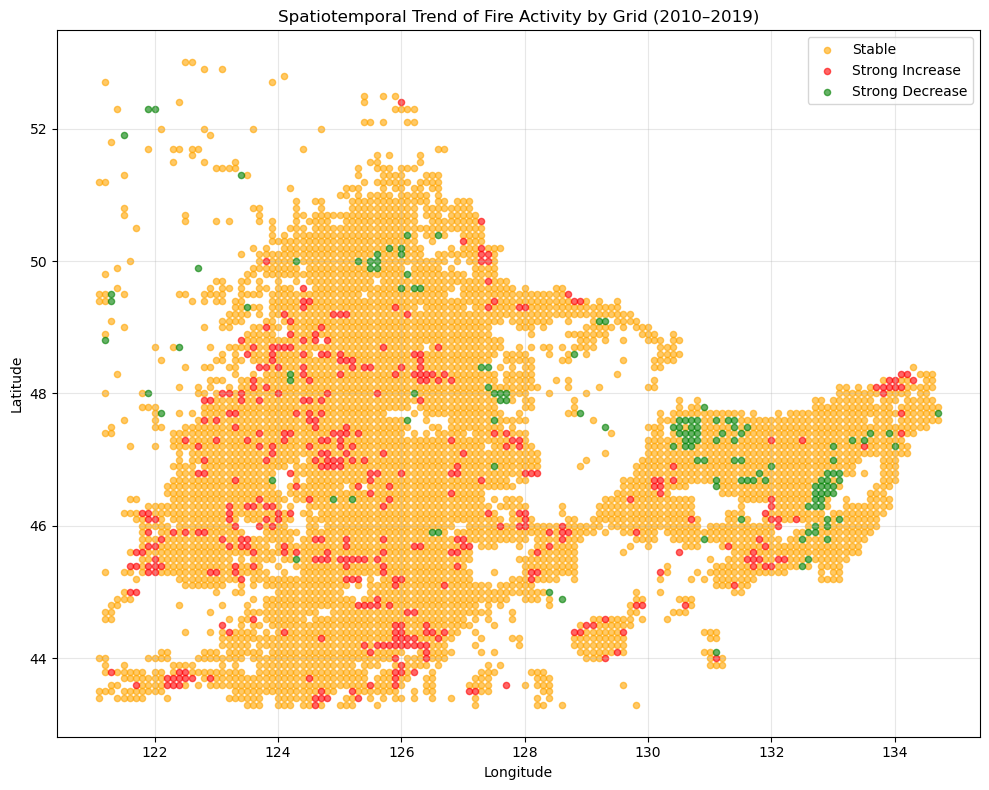

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
colors = {'Strong Decrease': 'v', 'Stable': 'orange', 'Strong Increase': 'red'}

for cat in df_trend['trend_category'].unique():
    subset = df_trend[df_trend['trend_category'] == cat]
    plt.scatter(subset['center_lon'], subset['center_lat'],
                c=colors.get(cat, 'black'), label=cat, alpha=0.6, s=20)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatiotemporal Trend of Fire Activity by Grid (2010–2019)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()